### Imports

In [1]:
from analyze_results import *
from getting_examples import *
from predict_activations import *
from model_utils import *
from utils import *
import json
import pprint

In [2]:
sae, model = load_sae_and_model()

/root/feature_benchmark/feat_bench/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
feat_id = 1

description, pos_examples, neg_examples, highest_activation = get_pos_neg_examples(feat_id, layer=6, basis='res-jb', num_pos=2, num_neg=2, neg_type='others', randomize_pos_examples=False)
print(description)

max_indices = [pos_examples[i]['max_value_token_index'] + 1 for i in range(len(pos_examples))] + [9 for i in range(len(neg_examples))]
strings = [pos_examples[i]['sentence_string'] for i in range(len(pos_examples))] + [neg_examples[i]['sentence_string'] for i in range(len(neg_examples))]

for pos in pos_examples:
    print(pos['sentence_string'])
    print(pos['values'])

for neg in neg_examples:
    print(neg['sentence_string'])
    print(neg['values'])

mentions of financial funding through grants
 published this spring, was funded through a grant from NHTSA and conducted through the
[0, 0, 0, 0, 0, 0, 0, 0, 49.51050567626953, 0.1973066926002502, 0, 0, 0, 0, 0, 0, 0]
I. will receive a three-year grant from the Massachusetts Service Alliance that will place
[0, 0, 0, 0, 0, 0, 0, 0, 48.00002670288086, 0, 0, 0, 0, 0, 0, 0, 0]
estlÃ© says it monitors environmental conditions around its source springs and that it adheres to
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 Buteo sync framework, and many more.ĊĊThese technologies are brought to
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [4]:
pre_acts, inner_acts, post_acts = get_sae_activations(model, sae, strings)

for inner_act in inner_acts:
    x = np.array(inner_act)
    print(x[:,feat_id])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         48.49956131  1.33336258  0.
  0.          0.          0.          0.          0.          0.        ]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         42.76519775  0.          0.
  0.          0.          0.          0.          0.          0.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
# Get model's loss on strings
regular_losses = get_vanilla_loss(model, sae, strings)
print(pretty_losses_fmt("Regular", strings, regular_losses))

# Get model's loss on strings using SAE reconstructed activations
sae_losses = get_vanilla_loss(model, sae, strings, with_sae_replacement=True)
print(pretty_losses_fmt("SAE", strings, sae_losses))

# Loss with all features ablated
precomputed_zeros = [[[0.0] * len(l) for l in seq] for seq in inner_acts]
zeros_losses = get_recons_loss_from_predicted_values(model, sae, strings, precomputed_zeros)
print(pretty_losses_fmt("Zeros", strings, zeros_losses))

Regular losses:
 published this spring, was funded through a grant from NHTSA and conducted through the (4.1803): 13.6845 6.9317 6.7337 2.1646 5.5099 5.8693 3.7500 1.0739 2.1365 0.1572 6.3267 4.8857 0.0050 2.3500 5.8504 2.4335 1.2026
I. will receive a three-year grant from the Massachusetts Service Alliance that will place (4.7467): 3.9997 6.1135 11.2789 7.5890 1.7388 7.5961 0.6220 2.4118 5.1721 1.0106 0.4074 5.7994 9.1498 5.7121 3.7558 0.5996 7.7381
estlÃ© says it monitors environmental conditions around its source springs and that it adheres to (5.3927): 9.0918 7.6301 12.2788 2.0547 9.6391 2.2804 10.9110 6.5867 2.5259 3.1299 1.7731 7.9130 9.9015 1.6393 4.6960 1.4904 8.8113 0.0424 0.0665
 Buteo sync framework, and many more.ĊĊThese technologies are brought to (6.2505): 10.1540 8.9555 6.2117 14.1162 11.0397 2.9629 4.3373 5.2385 2.8183 2.0363 13.5554 6.5102 4.9027 0.7697 9.4081 6.8016 1.1927 6.7976 0.9508
SAE losses:
 published this spring, was funded through a grant from NHTSA and cond

In [11]:
# Get model's loss on strings using SAE with selected feature ablated
replacements = [0 for string in strings]
ablated_inner_acts = replace_max_feature_activation(inner_acts, feat_id, max_indices, replacements)
ablated_sae_losses = get_recons_loss_from_predicted_values(model, sae, strings, ablated_inner_acts)
print(pretty_losses_fmt(f"SAE feature {feat_id} ablated", strings, ablated_sae_losses))

for inner_act in ablated_inner_acts:
    x = np.array(inner_act)
    print(x[:,feat_id])

# Print how much loss changes after ablating selected feature
difference = elementwise_difference(sae_losses, ablated_sae_losses)
rounded_difference = [[round(elem, 2) for elem in sublist] for sublist in difference]
print(rounded_difference)

SAE feature 1 ablated losses:
 published this spring, was funded through a grant from NHTSA and conducted through the (4.2348): 13.7159 5.8250 7.5830 1.0363 5.8370 7.0606 3.2471 1.2248 2.1267 0.7712 6.5461 4.4802 0.2106 2.4924 5.8819 2.7817 1.1709
I. will receive a three-year grant from the Massachusetts Service Alliance that will place (4.7978): 4.0963 5.9176 10.0126 7.4673 1.9837 7.4549 0.4112 1.9489 5.1028 1.6349 0.8448 6.5888 9.1750 6.6881 4.3267 0.9515 6.9573
estlÃ© says it monitors environmental conditions around its source springs and that it adheres to (5.6963): 9.0402 8.5270 11.8070 3.8688 9.4960 3.0640 9.9601 6.6278 3.3729 3.0518 3.7505 7.8556 10.0650 1.9072 5.0132 1.5749 9.0704 0.1174 0.0602
 Buteo sync framework, and many more.ĊĊThese technologies are brought to (6.3559): 10.1551 9.8049 5.1582 14.2513 9.2589 2.8932 4.2323 5.4076 3.2950 1.8616 13.6930 6.2208 3.9984 3.6078 11.5124 6.1163 1.3244 7.1624 0.8090
[0.         0.         0.         0.         0.         0.
 0.      

In [3]:
np.random.seed(42)
indices = np.random.choice(24576, size=100, replace=False)
print(indices)
copy_files_by_list(indices, 'gpt2-small-organized/6-res-jb', '6-res-jb_subset_100')

array([ 2350, 23251, 11000, 13627, 21896,  6332,  2534, 11263,  8913,
        9532,  5128,  5157, 15162, 12092, 19697, 15570, 21983,  3230,
       20780, 10322,  7428, 10949, 11451, 16697,  6750, 19453, 23607,
        1346,  4730, 21772, 11817, 20963, 17386, 20351, 20820,  3096,
        4634,  2830, 11212, 16183, 10404,  8064, 14882,  6448, 14583,
        1103, 10075,  5625,  9760,  3594, 20189,  2004, 11264,  8685,
       16693,  7476, 16596, 11799, 13133,  9658,  1202, 12694, 14524,
        4036, 19899,  4679, 14073, 14372, 14610, 15500, 21032,   752,
       18083,  7739, 11606,  3197, 14169, 19484, 22719,  8728,  7104,
       14931, 22832,  2858,  9002,   536,  7585, 17533,   428, 19505,
        6769,  2726, 13410, 22202,  3509,  9579,   681, 22138, 21380,
       15824])

### Run an experiment

In [224]:
results = run_experiments(
    num_features=100, 
    layer=6,
    basis='neurons',
    test_pos=2, # Experiment with
    test_neg=2, # Experiment with
    show_pos=0, # Experiment with
    show_neg=0, # Experiment with
    neg_type='others', # Experiment with
    binary_class=True, # Experiment with
    show_max_token=False, # Experiment with
    num_completions=1, # Experiment with
    debug=False, 
    randomize_pos=True, 
    seed=42,
    save_location='test'
)

# # the run_experiments function automatically saves results to results/exp_{timestamp}.json
pprint.pprint(results)

Submitted 1 of 10 tasks. Been running for 3 seconds
Submitted 2 of 10 tasks. Been running for 6 seconds
Submitted 3 of 10 tasks. Been running for 9 seconds
Submitted 4 of 10 tasks. Been running for 12 seconds
Submitted 5 of 10 tasks. Been running for 15 seconds
Submitted 6 of 10 tasks. Been running for 18 seconds
Submitted 7 of 10 tasks. Been running for 21 seconds
Submitted 8 of 10 tasks. Been running for 24 seconds
Submitted 9 of 10 tasks. Been running for 27 seconds
Submitted 10 of 10 tasks. Been running for 30 seconds
{'hyperparameters': {'binary_class': True,
                     'debug': False,
                     'neg_type': 'others',
                     'num_completions': 1,
                     'randomize_pos': True,
                     'seed': 42,
                     'show_max_token': False,
                     'show_neg': 0,
                     'show_pos': 0,
                     'test_neg': 2,
                     'test_pos': 2},
 'num_features': 10,
 'results': [{'de

### Do analysis on loaded json_data

In [ ]:
json_data_binary = load_json_results('results/binary_test/exp_binary_others.json')
json_data_continuous = load_json_results('results/binary_test/exp_continuous_others.json')

In [ ]:
binary_preds = [json_data_binary['results'][i]['gpt_predictions'] for i in range(len(json_data_binary['results']))]
continuous_preds = [json_data_continuous['results'][i]['gpt_predictions'] for i in range(len(json_data_continuous['results']))]

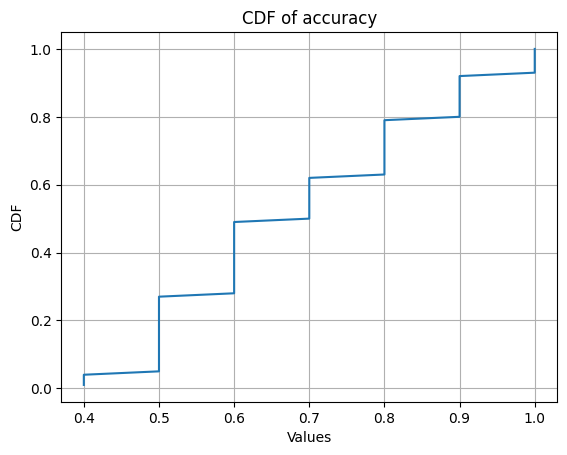

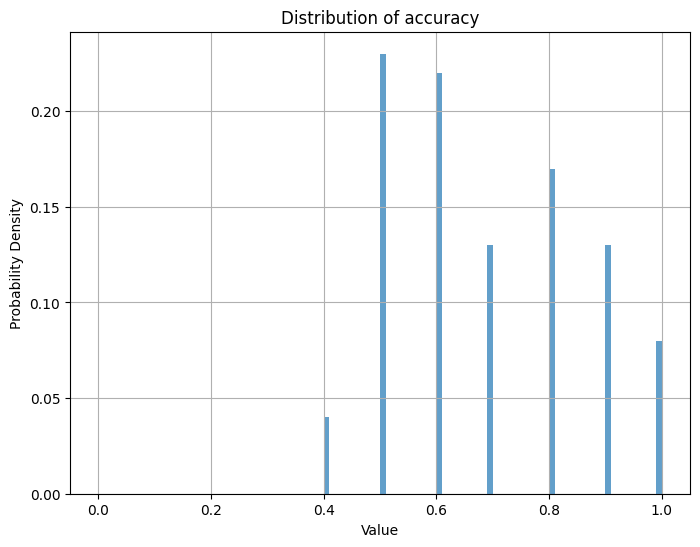

In [ ]:
accuracy = get_binary_accuracy(binary_preds, plot_cdf=True, plot_distribution=True)

In [ ]:
accuracy_descs = get_accuracy_descs(json_data_binary, include_pos_neg=True, display=True)

(0.4, 0.0, 0.8, 'dates or time-related information')
(0.4, 0.6, 0.2, 'words signaling conflicting or contrasting information')
(0.4, 0.0, 0.8, 'phrases related to legal issues and law enforcement')
(0.4, 0.0, 0.8, 'phrases that are commonly used in research or formal reports')
(0.5,
 0.0,
 1.0,
 'references to locations or events related to the state of Florida')
(0.5, 0.0, 1.0, 'metaphorical expressions related to success and achievement')
(0.5, 0.0, 1.0, 'numbers and financial terms')
(0.5, 0.2, 0.8, 'disparities between genders or races in various aspects')
(0.5, 0.0, 1.0, 'words related to elements from the periodic table')
(0.5, 0.0, 1.0, 'names of specific computer software or platforms')
(0.5, 0.0, 1.0, 'mentions of specific locations, with a focus on New York City')
(0.5,
 0.2,
 0.8,
 'instances where something is considered problematic or controversial')
(0.5, 0.0, 1.0, 'references to email sharing')
(0.5,
 0.0,
 1.0,
 'attributes related to products such as being inexpensive,

In [2]:
resave_organized_modeldata(autoencoder_layers = [6],
                        autoencoder_bases = [
                            'neurons',
                            'res-jb',])

gpt2-small/6/1248-1280.json
gpt2-small/6/1088-1120.json
gpt2-small/6/1056-1088.json
gpt2-small/6/192-224.json
gpt2-small/6/1312-1344.json
gpt2-small/6/608-640.json
gpt2-small/6/2624-2656.json
gpt2-small/6/224-256.json
gpt2-small/6/2720-2752.json
gpt2-small/6/1568-1600.json
gpt2-small/6/2240-2272.json
gpt2-small/6/960-992.json
gpt2-small/6/480-512.json
gpt2-small/6/2752-2784.json
gpt2-small/6/3008-3040.json
gpt2-small/6/128-160.json
gpt2-small/6/1504-1536.json
gpt2-small/6/2880-2912.json
gpt2-small/6/448-480.json
gpt2-small/6/2592-2624.json
gpt2-small/6/2976-3008.json
gpt2-small/6/2816-2848.json
gpt2-small/6/2944-2976.json
gpt2-small/6/1472-1504.json
gpt2-small/6/1824-1856.json
gpt2-small/6/1792-1824.json
gpt2-small/6/992-1024.json
gpt2-small/6/672-704.json
gpt2-small/6/1952-1984.json
gpt2-small/6/1920-1952.json
gpt2-small/6/1184-1216.json
gpt2-small/6/352-384.json
gpt2-small/6/160-192.json
gpt2-small/6/704-736.json
gpt2-small/6/2112-2144.json
gpt2-small/6/864-896.json
gpt2-small/6/928-